In [46]:
# 1. Import delle librerie
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC, LinearSVC

In [47]:
# 2. Caricamento del dataset
FFILE = "data/WELFake_Dataset.csv"

if os.path.isfile(FFILE):
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable")
else:
    print("Either the file is missing or not readable, download it")

File already exists
File is readable


In [48]:
# 3. Lettura e analisi preliminare
df = pd.read_csv(FFILE)
print("Prime righe del dataset:\n", df.head())
print("\nColonne disponibili:", df.columns.tolist())
print("\nInfo sul dataset:\n")
df.info()


Prime righe del dataset:
    Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  

Colonne disponibili: ['Unnamed: 0', 'title', 'text', 'label']

Info sul dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #


Distribuzione classi:
 label
0    34790
1    28329
Name: count, dtype: int64


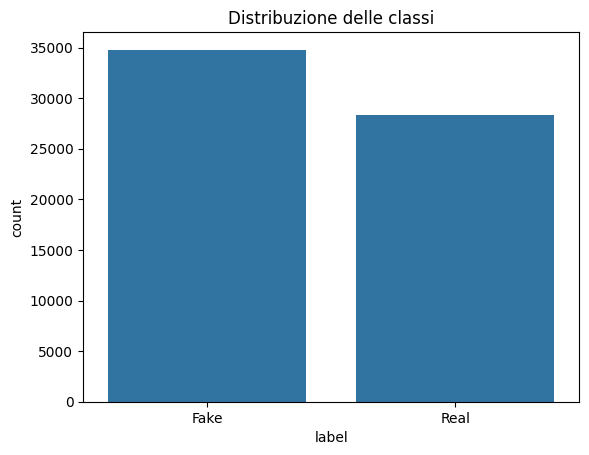

In [49]:
# 4. Pulizia iniziale dati

# Teniamo solo le colonne rilevanti
df = df[['title', 'text', 'label']]

# Rimuove righe con valori mancanti
df = df.dropna()

# Unisce il titolo con il testo per formare una rappresentazione più ricca
df['full_text'] = df['title'].str.strip() + ". " + df['text'].str.strip()

# Converte le etichette (se non sono già int)
df['label'] = df['label'].astype(int)

# Elimina eventuali duplicati
df = df.drop_duplicates(subset='full_text')

# Distribuzione delle classi (Fake = 0, Real = 1)
print("\nDistribuzione classi:\n", df['label'].value_counts())

# Visualizzazione distribuzione classi
sns.countplot(x='label', data=df)
plt.title("Distribuzione delle classi")
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()


In [50]:
# 5. Funzione di pulizia del testo
def clean_text(text):
    # Trasforma tutto in minuscolo
    text = text.lower()

    # Rimuove spazi multipli, tabulazioni e ritorni a capo
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Applichiamo la pulizia al testo combinato
df['clean_text'] = df['full_text'].apply(clean_text)


In [51]:
# 7. Trasformazione testo → numeri (TF-IDF)

# TF-IDF: Term Frequency - Inverse Document Frequency
# Serve per rappresentare il testo in forma numerica, pesando le parole in base a quanto sono "informative"
# (cioè comuni nel documento ma non troppo comuni ovunque)

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Applichiamo la trasformazione al testo pulito
X = vectorizer.fit_transform(df['clean_text'])

# Target (0 = fake, 1 = real)
y = df['label'].values


In [52]:
# 8. Split Train/Test

# Suddividiamo in training e test set (80% / 20%)
# stratify=y serve per mantenere la stessa proporzione di etichette (fake/real) nei due insiemi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {X_train.shape[0]} - Test size: {X_test.shape[0]}")


Train size: 50495 - Test size: 12624


In [53]:
# 1. Creo il modello di regressione logistica
#   - solver='liblinear' funziona bene su piccoli dataset di testo
#   - max_iter=100 per avere abbastanza iterazioni per convergere
model = LogisticRegression(solver='liblinear', max_iter=100)

# 2. Alleno il modello sui dati di training
model.fit(X_train, y_train)

# 3. Faccio la previsione sul test set
y_pred = model.predict(X_test)

# 4. Valuto le prestazioni del modello

# Accuracy = percentuale di predizioni corrette
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Report completo con precision, recall, f1-score per ogni classe
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matrice di confusione per vedere i falsi positivi e negativi
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)


Accuracy: 0.9419

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      6958
           1       0.94      0.93      0.94      5666

    accuracy                           0.94     12624
   macro avg       0.94      0.94      0.94     12624
weighted avg       0.94      0.94      0.94     12624


Confusion Matrix:
 [[6598  360]
 [ 373 5293]]


In [ ]:
# Modello SVM lineare
svm_linear = LinearSVC(random_state=0, max_iter=5000)
svm_linear.fit(X_train, y_train)

# Predizione
y_pred_linear = svm_linear.predict(X_test)

# Valutazione
print("SVM Lineare - Accuracy:", accuracy_score(y_test, y_pred_linear))
print("Classification Report SVM Lineare:\n", classification_report(y_test, y_pred_linear))


SVM Lineare - Accuracy: 0.9437579214195184
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6958
           1       0.94      0.94      0.94      5666

    accuracy                           0.94     12624
   macro avg       0.94      0.94      0.94     12624
weighted avg       0.94      0.94      0.94     12624



In [ ]:
# Modello SVM con kernel RBF (non lineare)
svm_rbf = SVC(kernel='rbf', random_state=0)
svm_rbf.fit(X_train, y_train)

# Predizione
y_pred_rbf = svm_rbf.predict(X_test)

# Valutazione
print("SVM con Kernel RBF - Accuracy:", accuracy_score(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))
